In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt


from torchvision import datasets, transforms
from torch.utils.data import DataLoader


import glob
from tqdm import tqdm #tqdm is a library in Python which is used for creating Progress Meters or Progress Bars. 
import warnings;
warnings.filterwarnings('ignore')
#refer 011 bm


In [2]:
import os
os.chdir("C:/Users/drang/downloads")


In [3]:
"""# download adn extract dataset
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
! tar -xvzf lfw.tgz"""

'# download adn extract dataset\n! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz\n! tar -xvzf lfw.tgz'

In [ ]:
#way1 of loading images

In [55]:
#capture paths to images- Globbing is the act of locating files on a filesystem using one or more globs. with re compile
face_images = glob.glob('lfw\**\*.jpg')

In [56]:
face_images

['lfw\\Aaron_Eckhart\\Aaron_Eckhart_0001.jpg',
 'lfw\\Aaron_Guiel\\Aaron_Guiel_0001.jpg',
 'lfw\\Aaron_Patterson\\Aaron_Patterson_0001.jpg',
 'lfw\\Aaron_Peirsol\\Aaron_Peirsol_0001.jpg',
 'lfw\\Aaron_Peirsol\\Aaron_Peirsol_0002.jpg',
 'lfw\\Aaron_Peirsol\\Aaron_Peirsol_0003.jpg',
 'lfw\\Aaron_Peirsol\\Aaron_Peirsol_0004.jpg',
 'lfw\\Aaron_Pena\\Aaron_Pena_0001.jpg',
 'lfw\\Aaron_Sorkin\\Aaron_Sorkin_0001.jpg',
 'lfw\\Aaron_Sorkin\\Aaron_Sorkin_0002.jpg',
 'lfw\\Aaron_Tippin\\Aaron_Tippin_0001.jpg',
 'lfw\\Abbas_Kiarostami\\Abbas_Kiarostami_0001.jpg',
 'lfw\\Abba_Eban\\Abba_Eban_0001.jpg',
 'lfw\\Abdel_Aziz_Al-Hakim\\Abdel_Aziz_Al-Hakim_0001.jpg',
 'lfw\\Abdel_Madi_Shabneh\\Abdel_Madi_Shabneh_0001.jpg',
 'lfw\\Abdel_Nasser_Assidi\\Abdel_Nasser_Assidi_0001.jpg',
 'lfw\\Abdel_Nasser_Assidi\\Abdel_Nasser_Assidi_0002.jpg',
 'lfw\\Abdoulaye_Wade\\Abdoulaye_Wade_0001.jpg',
 'lfw\\Abdoulaye_Wade\\Abdoulaye_Wade_0002.jpg',
 'lfw\\Abdoulaye_Wade\\Abdoulaye_Wade_0003.jpg',
 'lfw\\Abdoulaye_Wade\

In [57]:

all_images = []

for i in tqdm(face_images):
  img = load_img(i, target_size=(80,80,3)) #nwhc
  img = img_to_array(img)
  img = img/255.
  all_images.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 13233/13233 [00:32<00:00, 411.95it/s]


In [4]:
#way2 of loading images
trans = transforms.Compose([transforms.ToTensor(),
                           transforms.Resize(size=(80,80))])

train_imgs = datasets.ImageFolder(os.path.join(r"C:\Users\drang\downloads\lfwtor", "trainy"), transform=trans) #11k
test_imgs = datasets.ImageFolder(os.path.join(r"C:\Users\drang\downloads\lfwtor", "test"), transform=trans) #128

train_loader = DataLoader(train_imgs, batch_size=64, shuffle=True, pin_memory=True, num_workers=3, drop_last=True)
test_loader = DataLoader(test_imgs, batch_size=64, shuffle=False, pin_memory=True, num_workers=3, drop_last=True)


In [5]:
a,b = train_imgs[1]

torch.Size([3, 80, 80])


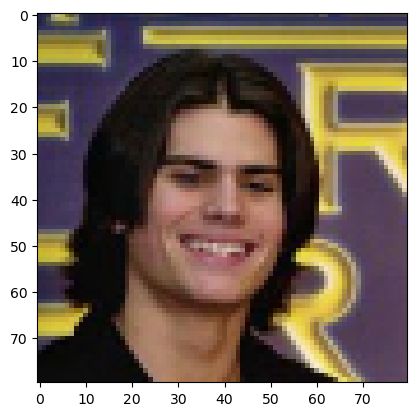

In [6]:
print(a.shape)
plt.imshow(np.transpose(a.numpy(),(1,2,0)))

In [7]:
import cv2
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image):
  scale_percent = 40
  #print(image.shape)
  image = np.transpose(image.numpy(), (1,2,0))
  #print(image.shape)
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)
  #print(low_res_image.shape)
  low_res_image = np.transpose(low_res_image, (2,0,1))
  low_res_image = torch.Tensor(low_res_image)
  #print(low_res_image.shape)
  return low_res_image


In [8]:
"""#using custom transforms by functions
trans = transforms.Compose([
                           transforms.Lambda(pixalate_image)])
a = trans(torch.Tensor(all_images[0]))
all_images[0].shape
a.shape
plt.imshow(a)
torch.ten"""

'#using custom transforms by functions\ntrans = transforms.Compose([\n                           transforms.Lambda(pixalate_image)])\na = trans(torch.Tensor(all_images[0]))\nall_images[0].shape\na.shape\nplt.imshow(a)\ntorch.ten'

In [9]:
#cv2 equivalent resizing in torchvision using pil packages
trans = transforms.Compose([transforms.ToTensor(),
                           transforms.Resize(size=(80,80)),
                           transforms.Lambda(pixalate_image)])# transforms.InterpolationMode.NEAREST equivalent near

train_im = datasets.ImageFolder(os.path.join(r"C:\Users\drang\downloads\lfwtor", "trainy"), transform=trans) #12000
test_im = datasets.ImageFolder(os.path.join(r"C:\Users\drang\downloads\lfwtor", "test"), transform=trans) #500
train_loadert = DataLoader(train_im, batch_size=64, shuffle=True, drop_last=True)
test_loadert = DataLoader(test_im, batch_size=64, shuffle=False, drop_last=True)

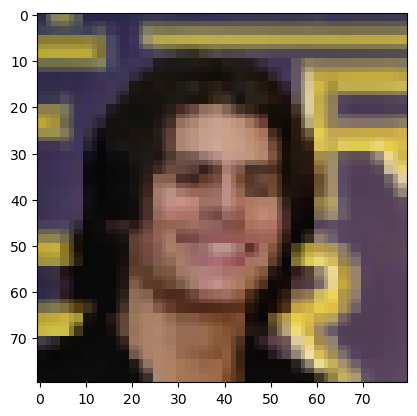

In [10]:
a, b = train_im[1]
train_im
plt.imshow(np.transpose(a.numpy(),(1,2,0)))#hwc

In [104]:
class AEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1e = nn.Conv2d(3, 256, 3, 1, padding=1)
        self.conv2e = nn.Conv2d(256, 128, 3, 1, padding=1)
        self.encode = nn.Conv2d(128, 64, 3, 1, padding=1)
        self.conv1d = nn.ConvTranspose2d(64, 128, 3, 1, padding=1)
        self.conv2d = nn.ConvTranspose2d(128, 256, 3, 1, padding=1)
        self.decode = nn.ConvTranspose2d(256, 3, 3, 1, padding=1)
        self.downs = nn.MaxPool2d(2,2)
        self.ups = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, x):
        x = F.relu(self.conv1e(x))
        x = F.relu(self.conv2e(x))
        x = self.downs(x)
        x_enc = F.relu(self.encode(x))
    
        x = F.relu(self.conv1d(x_enc))
        x = self.ups(x)
        x = F.relu(self.conv2d(x))
        x = self.decode(x)
        x = F.sigmoid(x)
        return x

In [13]:
torch.manual_seed(53)
model = AEModel()
gpumodel = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gpumodel.parameters(), lr=0.001)


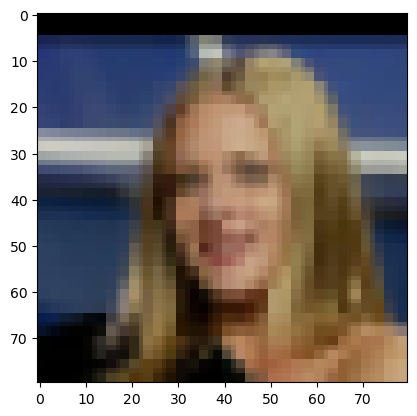

In [87]:
a,b = train_im[0]
yeet = np.transpose(a.cpu().detach().numpy(),(1,2,0))
plt.imshow(yeet)

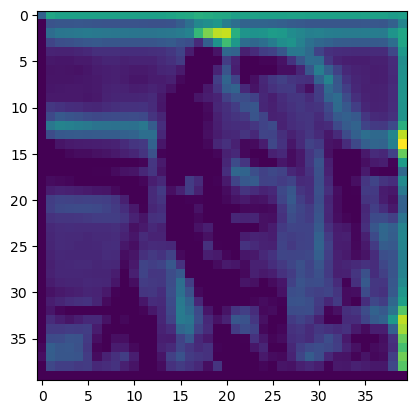

In [96]:
        #yee = gpumodel.conv1e(a.cuda())
        x = a.cuda()
        x = F.relu(gpumodel.conv1e(x))
        x = F.relu(gpumodel.conv2e(x))
        x = gpumodel.downs(x)
        x_enc = F.relu(gpumodel.encode(x))
        
        x = F.relu(gpumodel.conv1d(x_enc))
        XUP = nn.UpsamplingNearest2d(scale_factor=2)
        
        x =XUP(x)
        x = F.relu(gpumodel.conv2d(x))
        x = gpumodel.decode(x)
        xx = F.sigmoid(x)
        yee = np.transpose(x_enc.cpu().detach().numpy(),(1,2,0))
        plt.imshow(yee[:,:,2])

In [15]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(gpumodel)

    6912
     256
  294912
     128
   73728
      64
   73728
     128
  294912
     256
    6912
       3
________
  751939


In [28]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [16]:
y_train = []
for y, x in train_loader:
        y_train.append(y)
        

In [17]:
set : 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [18]:
y_test=[]
for y, x in test_loader:
        y_test.append(y)

In [19]:
#training ON 80*80 but using 32*32 resized to 80*80
#cv2 accepts Brg, NWHC input format
#Basically torchvision.transforms.Resize() uses PIL.Image.BILINEAR interpolation by default. pil uses some antialiasing filter vs cv(no use)
early_stopping = EarlyStopping(tolerance=40, min_delta=0.0000001)

import time
start_time = time.time()

epochs = 20

max_trn_batch = 1200
max_tst_batch = 500

train_loss = []
validation_loss = []
train_correct = []
test_correct = []
torch.backends.cudnn.benchmark = True




for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y) in enumerate(train_loadert):
        X_train = X_train.cuda()
        y = y.cuda()
        # Limit the number of batches
        y_try = y_train[b].cuda()
        if b == max_trn_batch:
            break
        b+=1
        
        
        # Apply the model
        y_pred = gpumodel(X_train)
        loss = criterion(y_pred, y_try)
        
           # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{64*b:6}/12800]  loss: {loss.cpu().item():10.8f}')

    train_loss.append(loss)
    


    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_t) in enumerate(test_loadert):
            # Limit the number of batches
            X_test = X_test.cuda()
            y_t = y_t.cuda()
            y_tes = y_test[b].cuda()
            if b == max_tst_batch:
                break
            
            # Apply the model
            y_val = gpumodel(X_test)


            loss = criterion(y_val, y_tes)
    validation_loss.append(loss)
    early_stopping(train_loss[i], validation_loss[i])
    if early_stopping.early_stop:
      print("We are at epoch:", i)
      break

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

NameError: name 'EarlyStopping' is not defined

In [30]:
print("Model's state_dict:")
for param_tensor in gpumodel.state_dict():
    print(param_tensor, "\t", gpumodel.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1e.weight 	 torch.Size([256, 3, 3, 3])
conv1e.bias 	 torch.Size([256])
conv2e.weight 	 torch.Size([128, 256, 3, 3])
conv2e.bias 	 torch.Size([128])
encode.weight 	 torch.Size([64, 128, 3, 3])
encode.bias 	 torch.Size([64])
conv1d.weight 	 torch.Size([64, 128, 3, 3])
conv1d.bias 	 torch.Size([128])
conv2d.weight 	 torch.Size([128, 256, 3, 3])
conv2d.bias 	 torch.Size([256])
decode.weight 	 torch.Size([256, 3, 3, 3])
decode.bias 	 torch.Size([3])
Optimizer's state_dict:
state 	 {0: {'step': tensor(2801.), 'exp_avg': tensor([[[[ 7.0642e-05,  7.3682e-05,  7.4446e-05],
          [ 6.4078e-05,  6.6286e-05,  6.6510e-05],
          [ 6.1821e-05,  6.3977e-05,  6.4159e-05]],

         [[ 7.0626e-05,  7.2882e-05,  7.3641e-05],
          [ 6.4743e-05,  6.6508e-05,  6.6622e-05],
          [ 6.1124e-05,  6.2957e-05,  6.2643e-05]],

         [[ 6.2926e-05,  6.5192e-05,  6.6000e-05],
          [ 5.7568e-05,  5.9356e-05,  5.9496e-05],
          [ 5.3114e-05,  5.5254e-05,  5.5275

In [80]:

gpumodel.load_state_dict =  torch.load("cv image varitionalae dnoisemodel.pt")
#gpumodel.load_optimizer_dict = torch.load("cv image denoiseoptmiz.pt")

In [22]:
plt.plot([t.cpu().detach().numpy() for t in train_loss])
plt.plot([t.cpu().detach().numpy() for t in validation_loss])

NameError: name 'train_loss' is not defined

In [82]:
for i, j in test_loadert:
    break
print(i.shape)


gpumodel.eval()
with torch.no_grad():
        i = i.cuda()
        pred = gpumodel(i)
pred[20].shape

torch.Size([64, 3, 80, 80])


torch.Size([3, 80, 80])

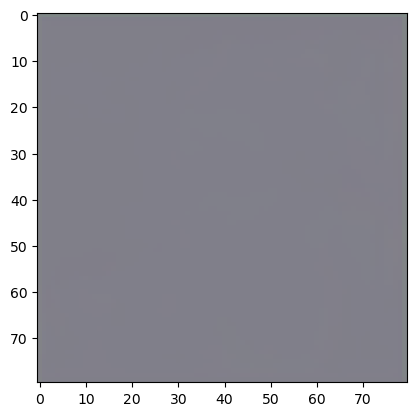

In [83]:
# training for 50+ epochs needed where i did 20 epochs
yeet = np.transpose(pred[20].cpu().detach().numpy(),(1,2,0))
plt.imshow(yeet[:,:,:])


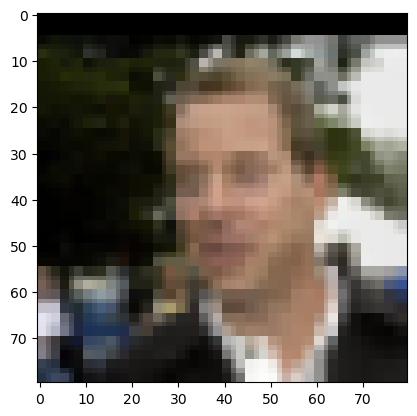

In [84]:
a = i[0, 0, :, :]
a.shape
plt.imshow(np.transpose(i[20].cpu().detach().numpy(),(1,2,0)))

In [64]:
#debugging each layers
with torch.no_grad():
    i = i.cuda()
    a= gpumodel.conv1e(i)
    a = gpumodel.conv2e(a)
    a = gpumodel.downs(a)
    a = gpumodel.encode(a)
    
    a = gpumodel.conv1d(a)
    a = gpumodel.ups(a)
    a = gpumodel.conv2d(a)
    a = gpumodel.decode(a)
    
    """x = F.relu(gpumodel.conv1e(x))
    x = F.relu(gpumodel.conv2e(x))
    x = gpumodel.downs(x)
    x_enc = F.relu(gpumodel.encode(x))

    x = F.relu(gpumodel.conv1d(x_enc))
    x = gpumodel.ups(x)
    x = F.relu(gpumodel.conv2d(x))
    x = gpumodel.decode(x)
    """
a = a[0, :, :, :]
a.shape

torch.Size([3, 80, 80])

In [38]:
plt.imshow(np.transpose(a.cpu().detach().numpy(),(1,2,0)))
#plt.imshow(a.cpu().numpy())


NameError: name 'a' is not defined

In [ ]:
#to view convolution filters
    import numpy as np
    import matplotlib.pyplot as plt
    from torchvision import utils

    def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))


    if __name__ == "__main__":
        layer = 1
        filter = model.features[layer].weight.data.clone()
        visTensor(filter, ch=0, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

In [47]:
# tutorials

'C:\\Users\\drang\\downloads'

In [48]:
#deep autoencoder format 1 for text or 2d MNIST
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #Encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256) # Input image (28*28 = 784)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)

        #Decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784) # Output image (28*28 = 784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))

        return x

In [49]:
#format convolutional autoencoder
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)
criterion = nn.BCELoss()
#or crossentropyloss

In [ ]:
#with skip connections which helps in addressing degradation problems of deeper nn
class Hourglass_net(nn.Module):
    def __init__(self):
        super(Hourglass_net, self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.conv_1 = nn.Conv2d(3, 8, 5, stride=2, padding=2)
        self.bn_1 = nn.BatchNorm2d(8)

        self.conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.bn_2 = nn.BatchNorm2d(16)
        self.skip_conv_2 = nn.Conv2d(16, 5, 5, stride=1, padding=2)

        self.conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.bn_3 = nn.BatchNorm2d(32)
        self.skip_conv_3 = nn.Conv2d(32, 5, 5, stride=1, padding=2)

        self.conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.bn_4 = nn.BatchNorm2d(64)
        self.skip_conv_4 = nn.Conv2d(64, 5, 5, stride=1, padding=2)

        self.conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.bn_5 = nn.BatchNorm2d(128)
        self.skip_conv_5 = nn.Conv2d(128, 5, 5, stride=1, padding=2)

        self.conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.bn_6 = nn.BatchNorm2d(256)

        self.upconv_5 = nn.ConvTranspose2d(256, 123, 4, stride=2, padding=1)
        self.upbn_5 = nn.BatchNorm2d(128)

        self.upconv_4 = nn.ConvTranspose2d(128, 59, 4, stride=2, padding=1)
        self.upbn_4 = nn.BatchNorm2d(64)

        self.upconv_3 = nn.ConvTranspose2d(64, 27, 4, stride=2, padding=1)
        self.upbn_3 = nn.BatchNorm2d(32)

        self.upconv_2 = nn.ConvTranspose2d(32, 11, 4, stride=2, padding=1)
        self.upbn_2 = nn.BatchNorm2d(16)

        self.upconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.upbn_1 = nn.BatchNorm2d(8)

        self.out_conv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, z):
        x = self.leaky_relu(self.bn_1(self.conv_1(z)))
        
        x = self.leaky_relu(self.bn_2(self.conv_2(x)))
        skip_2 = self.skip_conv_2(x)

        x = self.leaky_relu(self.bn_3(self.conv_3(x)))
        skip_3 = self.skip_conv_3(x)

        x = self.leaky_relu(self.bn_4(self.conv_4(x)))
        skip_4 = self.skip_conv_4(x)

        x = self.leaky_relu(self.bn_5(self.conv_5(x)))
        skip_5 = self.skip_conv_5(x)

        x = self.leaky_relu(self.bn_6(self.conv_6(x)))

        x = torch.cat([self.upconv_5(x), skip_5], dim=1)
        x = self.leaky_relu(self.upbn_5(x))

        x = torch.cat([self.upconv_4(x), skip_4], dim=1)
        x = self.leaky_relu(self.upbn_4(x))

        x = torch.cat([self.upconv_3(x), skip_3], dim=1)
        x = self.leaky_relu(self.upbn_3(x))

        x = torch.cat([self.upconv_2(x), skip_2], dim=1)
        x = self.leaky_relu(self.upbn_2(x))

        x = self.leaky_relu(self.upbn_1(self.upconv_1(x)))

        out = nn.Sigmoid()(self.out_bn(self.out_conv(x)))

        return out

In [ ]:
#can also use variational autoencoder which learns coding space in distribution space

In [11]:

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        self.linear3 = nn.Linear(784,19200)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 3, 80, 80))

In [13]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear0 = nn.Linear(19200,784)
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear0(x))
        x = F.relu(self.linear1(x))
        #print("varaenco", x.shape) 64,512
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        #print(z.shape)64,40
        return z

In [14]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [15]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.cuda() # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
        print("epoch:", epoch, "loss", loss)
    return autoencoder

In [16]:
torch.manual_seed(53)
model = VariationalAutoencoder(latent_dims=40)
gpumodel = model.cuda()
#criterion = kl div
optimizer = torch.optim.Adam(gpumodel.parameters(), lr=0.001)



In [28]:
gpumodel = train(gpumodel, train_loader)

  5%|████▏                                                                              | 1/20 [00:13<04:23, 13.87s/it]

epoch: 0 loss tensor(31450.2344, device='cuda:0', grad_fn=<AddBackward0>)


 10%|████████▎                                                                          | 2/20 [00:27<04:08, 13.81s/it]

epoch: 1 loss tensor(31520.1523, device='cuda:0', grad_fn=<AddBackward0>)


 15%|████████████▍                                                                      | 3/20 [00:41<03:55, 13.87s/it]

epoch: 2 loss tensor(31076.7480, device='cuda:0', grad_fn=<AddBackward0>)


 20%|████████████████▌                                                                  | 4/20 [00:55<03:41, 13.85s/it]

epoch: 3 loss tensor(31747.2773, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████████████████████▊                                                              | 5/20 [01:09<03:31, 14.09s/it]

epoch: 4 loss tensor(32705.0293, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████████████████████████▉                                                          | 6/20 [01:24<03:17, 14.13s/it]

epoch: 5 loss tensor(30686.4688, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████████████████████████████                                                      | 7/20 [01:38<03:04, 14.17s/it]

epoch: 6 loss tensor(28291.8281, device='cuda:0', grad_fn=<AddBackward0>)


 40%|█████████████████████████████████▏                                                 | 8/20 [01:52<02:49, 14.11s/it]

epoch: 7 loss tensor(30018.9727, device='cuda:0', grad_fn=<AddBackward0>)


 45%|█████████████████████████████████████▎                                             | 9/20 [02:06<02:35, 14.11s/it]

epoch: 8 loss tensor(31464.1289, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████████████████████████████████████████                                         | 10/20 [02:20<02:21, 14.14s/it]

epoch: 9 loss tensor(29469.6973, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████████████████████████████████████████████                                     | 11/20 [02:34<02:07, 14.15s/it]

epoch: 10 loss tensor(29267.5059, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:49<01:54, 14.29s/it]

epoch: 11 loss tensor(28530.7598, device='cuda:0', grad_fn=<AddBackward0>)


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:04<01:41, 14.43s/it]

epoch: 12 loss tensor(28256.9023, device='cuda:0', grad_fn=<AddBackward0>)


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:18<01:25, 14.31s/it]

epoch: 13 loss tensor(29579.2090, device='cuda:0', grad_fn=<AddBackward0>)


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:32<01:11, 14.25s/it]

epoch: 14 loss tensor(29580.3379, device='cuda:0', grad_fn=<AddBackward0>)


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:46<00:56, 14.22s/it]

epoch: 15 loss tensor(29767.5820, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [04:00<00:42, 14.11s/it]

epoch: 16 loss tensor(28042.3359, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:17<00:30, 15.11s/it]

epoch: 17 loss tensor(27566.4336, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:31<00:14, 14.81s/it]

epoch: 18 loss tensor(28655.6133, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:46<00:00, 14.30s/it]

epoch: 19 loss tensor(30009.0859, device='cuda:0', grad_fn=<AddBackward0>)


In [29]:
torch.save(gpumodel.state_dict(), "cv image varitionalae dnoisemodel1.pt")
torch.save(optimizer.state_dict(), "cv image varae denoiseoptmiz1.pt")

In [17]:

gpumodel.load_state_dict =  torch.load("cv image varitionalae dnoisemodel.pt")
gpumodel.load_optimizer_dict = torch.load("cv image denoiseoptmiz.pt")

In [31]:
for i, j in test_loadert:
    break
print("shape:",i.shape)


gpumodel.eval()
with torch.no_grad():
        i = i.cuda()
        pred = gpumodel(i)


shape: torch.Size([64, 3, 80, 80])


In [32]:
pred.shape

torch.Size([64, 3, 80, 80])

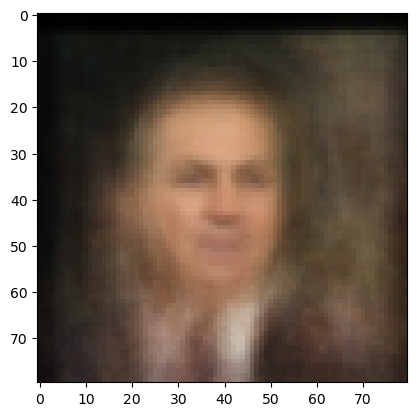

In [33]:
#our predicted denoised image

plt.imshow(np.transpose(pred[0].cpu().detach().numpy(),(1,2,0)))

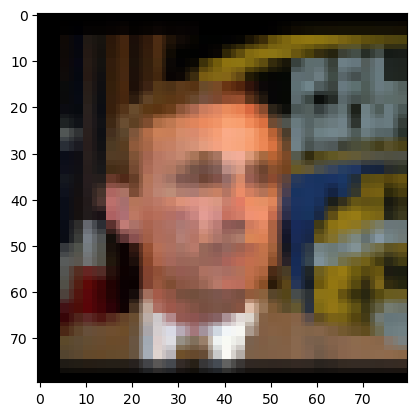

In [34]:
#blur image as input
plt.imshow(np.transpose(i[0].cpu().detach().numpy(),(1,2,0)))


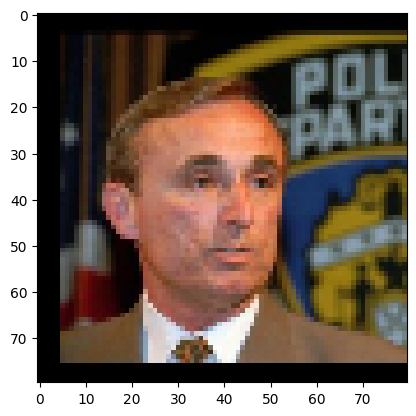

In [45]:
#original image hd
for a, b in test_loader:
    break

plt.imshow(np.transpose(a[0].numpy(),(1,2,0)))#hwc

In [39]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.cuda())
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

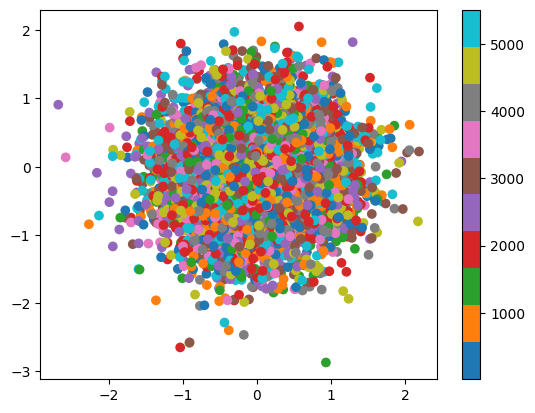

In [40]:
plot_latent(gpumodel, train_loader)

In [50]:
# this is elbo AVE uses reconstruct loss
import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

ModuleNotFoundError: No module named 'pytorch_lightning'